In [1]:
import os
import cv2
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pycocotools.mask as mask_utils # import encode, decode, frPyObjects, toBbox, area
from sklearn.model_selection import KFold
from itertools import product

def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, float) and np.isnan(enc):
            continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape)

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

file_names = glob.glob("./train/images/*.png")
labels = pd.read_csv("./train.csv")
labels

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [3]:
all_categories = [{"id":(i + 1), "name": v} for i, v in enumerate(labels.cell_type.unique())]
category_dict = {v: i + 1 for i, v in enumerate(labels.cell_type.unique())}
all_categories

[{'id': 1, 'name': 'shsy5y'},
 {'id': 2, 'name': 'astro'},
 {'id': 3, 'name': 'cort'}]

In [5]:
# all_categories = [{"id": 1, "name": "cell"}]

split = KFold(5, random_state = 0, shuffle = True)
img_ids = np.array(labels.id.unique())
splits = list(split.split(img_ids))

all_images = []
all_annotations = []
for fold in range(5):
    images = []
    annotations = []
    train_idx, valid_idx = splits[fold]
    train_img_ids = img_ids[train_idx]
    valid_img_ids = img_ids[valid_idx]
    print(labels[labels.id.isin(valid_img_ids)].cell_type.value_counts())
    for img_id in tqdm(valid_img_ids):
        group = labels[labels.id == img_id]
        height, width = (int(group.height.unique()[0]), int(group.width.unique()[0]))
        masks = group.annotation.tolist()
        cell_types = group.cell_type.tolist()
        assert len(set(cell_types)) == 1
        img = cv2.imread(os.path.join("./train/images", img_id + ".png"))
        H, W = img.shape[:2]

        ms = []
        for mask, cell_type in zip(masks, cell_types):
            mask = np.asfortranarray(enc2mask([mask], (height, width)))

            ms.append(mask)
        ms = np.stack(ms, -1)
        ms_sum = ms.sum((0,1))
        cuts = 4
        wstarts = W * np.arange(cuts).astype(int) // (cuts + 1)
        wends = W * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
        hstarts = H * np.arange(cuts).astype(int) // (cuts + 1)
        hends = H * np.arange(2, cuts + 2).astype(int) // (cuts + 1)
        for i, j in product(range(cuts), range(cuts)):
            
            img_cut = img[hstarts[i]:hends[i],wstarts[j]:wends[j]]
            mask_cut = ms[hstarts[i]:hends[i],wstarts[j]:wends[j]]
            mask_cut = mask_cut[...,mask_cut.sum((0,1)) > 0.25 * ms_sum]
            cv2.imwrite(os.path.join("./train_tiny/images", f"{img_id}_{i}_{j}.jpg"), img_cut)
            images.append({
                "id": f"{img_id}_{i}_{j}",
                "file_name": f"{img_id}_{i}_{j}.jpg",
                "width": img_cut.shape[1],
                "height": img_cut.shape[0]
            })
            for l in range(mask_cut.shape[-1]):
                rle = mask_utils.encode(mask_cut[...,l])
                rle['counts'] = rle['counts'].decode()
                bbox = [int(_) for _ in mask_utils.toBbox(rle)]
                area = mask_utils.area(rle)
                annotations.append({
                    "id": len(annotations),
                    "image_id": f"{img_id}_{i}_{j}",
                    "category_id": category_dict[cell_types[0]],
                    "bbox": bbox,
                    "segmentation": rle,
                    "iscrowd": 0,
                    "area": int(area)
                })

    with open(f"./train_tiny/annotations/fold_{fold}.json", "w") as f:
        json.dump({"images": images, "annotations": annotations, "categories": all_categories}, f)
#         json.dump({"images": images, "annotations": annotations, "categories": [{"id": 1, "name": "cort"}]}, f)
        
with open(f"./train/annotations/train.json", "w") as f:
    json.dump({"images": all_images, "annotations": all_annotations, "categories": all_categories}, f)

shsy5y    11716
astro      2171
cort       1986
Name: cell_type, dtype: int64


  0%|          | 0/122 [00:00<?, ?it/s]

shsy5y    10784
cort       2138
astro      1550
Name: cell_type, dtype: int64


  0%|          | 0/121 [00:00<?, ?it/s]

shsy5y    9095
cort      2271
astro     2089
Name: cell_type, dtype: int64


  0%|          | 0/121 [00:00<?, ?it/s]

shsy5y    10051
cort       2082
astro      2044
Name: cell_type, dtype: int64


  0%|          | 0/121 [00:00<?, ?it/s]

shsy5y    10640
astro      2668
cort       2300
Name: cell_type, dtype: int64


  0%|          | 0/121 [00:00<?, ?it/s]

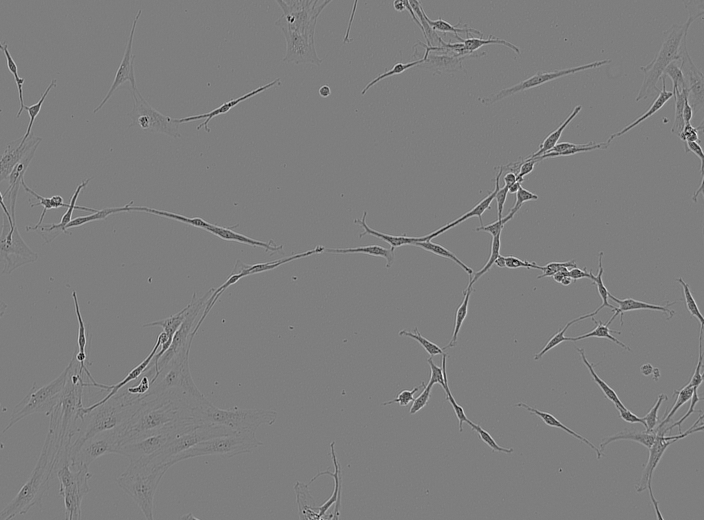

In [22]:
norm = lambda x: ((x - np.min(x)) / np.ptp(x) * 255).astype(np.uint8)

Image.fromarray(norm(img))


In [26]:
from pycocotools.coco import COCO
gt = COCO("./train/annotations/train.json")

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


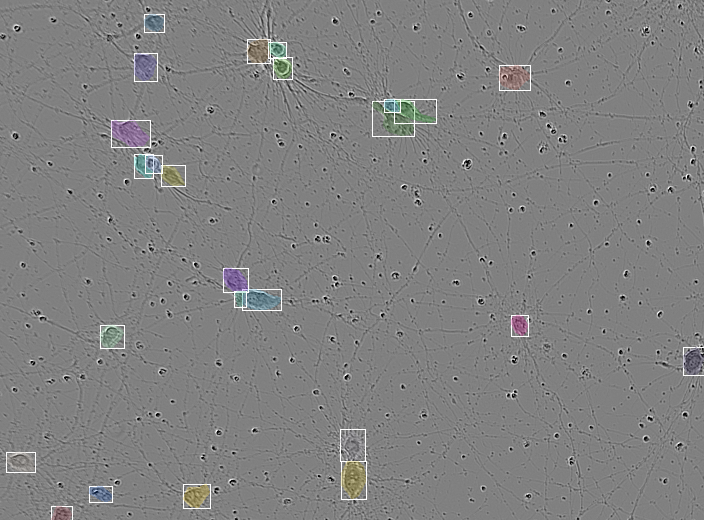

In [61]:
for img_id in gt.imgs:
    break
img_id = list(gt.imgs)[14]
gt.imgs[img_id]
img = cv2.imread(os.path.join("./train/images", gt.imgs[img_id]["file_name"]))
for ann_id in gt.getAnnIds(imgIds = [img_id]):
    ann_item = gt.anns[ann_id]
    # break
    x, y, w, h = [int(_) for _ in ann_item["bbox"]]
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 1)
#     mask = np.zeros(img.shape[:2], dtype = np.uint8)
#     mask = cv2.fillPoly(mask, [np.array(ann_item["segmentation"]).astype(int).reshape(-1, 2)], 1)
    mask = mask_utils.decode(ann_item["segmentation"])
    img[mask != 0] = img[mask != 0] // 4 * 3 + np.random.randint(0, 256, 3).astype(np.uint8) // 4

Image.fromarray(img)